## Assignment-2
We first import the libraries necassary for developing a trading strategy, numpy, pandas and yfinance. Also we imported matplotlib.pyplot as it helped us visualise the keltner bands and stock prices

In [193]:
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt

%matplotlib inline

In this cell, we decide a stock on which we need to apply our trading strategy, and we download the data of that stock for the timeframe we need to backtest it on. 

In [194]:
stock='AAPL'
data=yf.download(stock,'2013-06-14','2023-06-14')
data['Price']=(data['Open']+data['High']+data['Low']+data['Close'])/4
print(data)

[*********************100%***********************]  1 of 1 completed
                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2013-06-14   15.550000   15.581786   15.303571   15.358929   13.334579   
2013-06-17   15.408571   15.560714   15.370000   15.428571   13.395039   
2013-06-18   15.412857   15.532143   15.364643   15.420357   13.387908   
2013-06-19   15.407143   15.416429   15.107143   15.107143   13.115978   
2013-06-20   14.975000   15.213571   14.827500   14.887143   12.924975   
...                ...         ...         ...         ...         ...   
2023-06-07  178.440002  181.210007  177.320007  177.820007  177.820007   
2023-06-08  177.899994  180.839996  177.460007  180.570007  180.570007   
2023-06-09  181.500000  182.229996  180.630005  180.960007  180.960007   
2023-06-12  181.270004  183.889999  180.970001  183.789993  183.789993   
2023-06-13  182.800003  184.149994  182.440

Here, we define the function for calculating the upper, middle and lower bands of keltner channel.

In [195]:
def calculate_keltner_channel(data, window=20, multiplier=2):
    
    middle_line = data['Price'].rolling(window).mean()
    
    atr = calculate_atr(data, window)
    upper_band = middle_line + multiplier * atr
    lower_band = middle_line - multiplier * atr
    
    return middle_line, upper_band, lower_band

def calculate_atr(data, window=14):
    data['H-L'] = data['High'] - data['Low']
    data['H-PC'] = abs(data['High'] - data['Close'].shift(1))
    data['L-PC'] = abs(data['Low'] - data['Close'].shift(1))
    data['TR'] = data[['H-L', 'H-PC', 'L-PC']].max(axis=1)

    atr = data['TR'].rolling(window).mean()

    return atr

In [196]:
keltner_middle, upper_band, lower_band = calculate_keltner_channel(data, multiplier=2)
print("Middle Line:\n", keltner_middle)
print("Upper Band:\n", upper_band)
print("Lower Band:\n", lower_band)

Middle Line:
 Date
2013-06-14           NaN
2013-06-17           NaN
2013-06-18           NaN
2013-06-19           NaN
2013-06-20           NaN
                 ...    
2023-06-07    175.235001
2023-06-08    175.538251
2023-06-09    175.925251
2023-06-12    176.408626
2023-06-13    176.943501
Name: Price, Length: 2517, dtype: float64
Upper Band:
 Date
2013-06-14           NaN
2013-06-17           NaN
2013-06-18           NaN
2013-06-19           NaN
2013-06-20           NaN
                 ...    
2023-06-07    180.666002
2023-06-08    181.081252
2023-06-09    181.392251
2023-06-12    181.862625
2023-06-13    182.394499
Length: 2517, dtype: float64
Lower Band:
 Date
2013-06-14           NaN
2013-06-17           NaN
2013-06-18           NaN
2013-06-19           NaN
2013-06-20           NaN
                 ...    
2023-06-07    169.804000
2023-06-08    169.995250
2023-06-09    170.458251
2023-06-12    170.954627
2023-06-13    171.492503
Length: 2517, dtype: float64


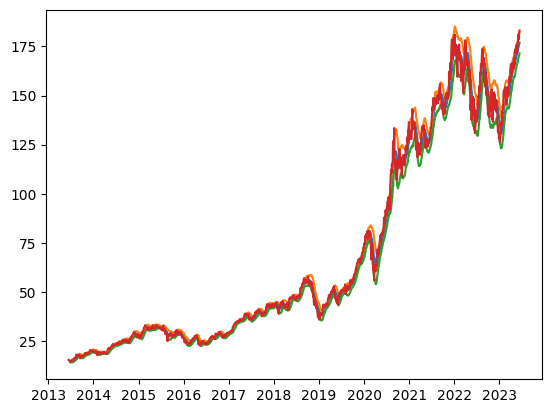

In [197]:
plt.figure()
plt.plot(keltner_middle.index, keltner_middle)
plt.plot(upper_band.index, upper_band)
plt.plot(lower_band.index, lower_band)
plt.plot(data.index, data['Price'])

Here, we define the function for calculating rsi values of the stock.

In [198]:
def calculate_rsi(data, window=14):
    price_change = data.diff(1)

    up_prices = price_change.where(price_change > 0, 0)
    down_prices = price_change.where(price_change < 0, 0)

    avg_gain = up_prices.rolling(window).mean()
    avg_loss = down_prices.abs().rolling(window).mean()

    rsi = 100 - (100 / (1 + (avg_gain/avg_loss)))
    return rsi
rsi_values = calculate_rsi(data['Close'])
print(rsi_values)

Date
2013-06-14          NaN
2013-06-17          NaN
2013-06-18          NaN
2013-06-19          NaN
2013-06-20          NaN
                ...    
2023-06-07    63.723928
2023-06-08    64.465419
2023-06-09    64.979346
2023-06-12    72.585975
2023-06-13    80.807589
Name: Close, Length: 2517, dtype: float64


### Backtesting Keltner channel
In the next two code cells, we are using the signals generated from keltner channel and backtesting it for the given stock.

In [199]:
keltner_sell_signals = []
keltner_buy_signals = []
keltner_signals = []

keltner_status = ''
for i in range(len(keltner_middle)):
    if upper_band[i] < data['Price'][i] and keltner_status != 'SELL':
        keltner_sell_signals.append(i)
        keltner_signals.append((i,'SELL'))
        keltner_status = 'SELL'
    elif lower_band[i] > data['Price'][i] and keltner_status != 'BUY':
        keltner_buy_signals.append(i)
        keltner_signals.append((i,'BUY'))
        keltner_status = 'BUY'
    else:
        keltner_signals.append((i, 'NONE'))

print(keltner_sell_signals)
print(keltner_buy_signals)
print(keltner_signals)

[27, 88, 216, 409, 527, 595, 684, 742, 777, 820, 882, 1031, 1094, 1183, 1231, 1292, 1416, 1507, 1571, 1719, 1845, 1967, 2019, 2105, 2210, 2287, 2418]
[61, 156, 379, 520, 538, 630, 721, 763, 816, 854, 1005, 1076, 1164, 1201, 1266, 1364, 1487, 1545, 1684, 1829, 1935, 1990, 2081, 2166, 2231, 2318]
[(0, 'NONE'), (1, 'NONE'), (2, 'NONE'), (3, 'NONE'), (4, 'NONE'), (5, 'NONE'), (6, 'NONE'), (7, 'NONE'), (8, 'NONE'), (9, 'NONE'), (10, 'NONE'), (11, 'NONE'), (12, 'NONE'), (13, 'NONE'), (14, 'NONE'), (15, 'NONE'), (16, 'NONE'), (17, 'NONE'), (18, 'NONE'), (19, 'NONE'), (20, 'NONE'), (21, 'NONE'), (22, 'NONE'), (23, 'NONE'), (24, 'NONE'), (25, 'NONE'), (26, 'NONE'), (27, 'SELL'), (28, 'NONE'), (29, 'NONE'), (30, 'NONE'), (31, 'NONE'), (32, 'NONE'), (33, 'NONE'), (34, 'NONE'), (35, 'NONE'), (36, 'NONE'), (37, 'NONE'), (38, 'NONE'), (39, 'NONE'), (40, 'NONE'), (41, 'NONE'), (42, 'NONE'), (43, 'NONE'), (44, 'NONE'), (45, 'NONE'), (46, 'NONE'), (47, 'NONE'), (48, 'NONE'), (49, 'NONE'), (50, 'NONE'),

In [200]:
keltner_investment=100000
keltner_number_of_stocks=keltner_investment//(data['Close'][0])
keltner_in_hand = keltner_investment - keltner_number_of_stocks * data['Close'][0]

for i in range(len(keltner_signals)):
    if keltner_signals[i][1]=='BUY':
        temp = keltner_in_hand // data['Close'][i]
        keltner_in_hand -= temp * data['Close'][i]
        keltner_number_of_stocks += temp
    elif keltner_signals[i][1]=='SELL':
        keltner_in_hand += keltner_number_of_stocks * data['Close'][i]
        keltner_number_of_stocks = 0

keltner_returns=keltner_in_hand + keltner_number_of_stocks * data['Close'][-1]
print("The return on investing 100000 rupees is:",keltner_returns)

keltner_percentage_returns=format((((keltner_returns)-(keltner_investment))/keltner_investment)*(100),".2f")
print("The percentage return in case of keltner channel is:",keltner_percentage_returns,"%")

The return on investing 100000 rupees is: 260440.2087574005
The percentage return in case of keltner channel is: 160.44 %


### Backtesting Relative strength index
In the next two code cells, we are using the signals generated from relative strength index and backtesting it for the given stock.

In [201]:
rsi_sell_signals = []
rsi_buy_signals = []
rsi_signals = []

rsi_status = ''
#buy_threshold=70 & sell_threshold=30
for i in range(len(data)):
    if rsi_values[i] > 70 and rsi_status != 'SELL':
        rsi_sell_signals.append(i)
        rsi_signals.append((i,'SELL'))
        rsi_status = 'SELL'
    elif rsi_values[i] < 30 and rsi_status != 'BUY':
        rsi_buy_signals.append(i)
        rsi_signals.append((i,'BUY'))
        rsi_status = 'BUY'
    else:
        rsi_signals.append((i, 'NONE'))

print(rsi_sell_signals)
print(rsi_buy_signals)
print(rsi_signals)

[20, 88, 170, 217, 414, 469, 595, 684, 742, 777, 829, 886, 977, 1030, 1092, 1183, 1219, 1286, 1418, 1509, 1718, 1873, 1967, 2016, 2105, 2212, 2282, 2418]
[64, 162, 209, 379, 439, 504, 631, 721, 758, 816, 853, 968, 1005, 1075, 1168, 1202, 1265, 1366, 1487, 1685, 1831, 1931, 1991, 2081, 2165, 2231, 2321]
[(0, 'NONE'), (1, 'NONE'), (2, 'NONE'), (3, 'NONE'), (4, 'NONE'), (5, 'NONE'), (6, 'NONE'), (7, 'NONE'), (8, 'NONE'), (9, 'NONE'), (10, 'NONE'), (11, 'NONE'), (12, 'NONE'), (13, 'NONE'), (14, 'NONE'), (15, 'NONE'), (16, 'NONE'), (17, 'NONE'), (18, 'NONE'), (19, 'NONE'), (20, 'SELL'), (21, 'NONE'), (22, 'NONE'), (23, 'NONE'), (24, 'NONE'), (25, 'NONE'), (26, 'NONE'), (27, 'NONE'), (28, 'NONE'), (29, 'NONE'), (30, 'NONE'), (31, 'NONE'), (32, 'NONE'), (33, 'NONE'), (34, 'NONE'), (35, 'NONE'), (36, 'NONE'), (37, 'NONE'), (38, 'NONE'), (39, 'NONE'), (40, 'NONE'), (41, 'NONE'), (42, 'NONE'), (43, 'NONE'), (44, 'NONE'), (45, 'NONE'), (46, 'NONE'), (47, 'NONE'), (48, 'NONE'), (49, 'NONE'), (50, 

In [202]:
rsi_investment=100000
rsi_number_of_stocks=rsi_investment//(data['Close'][0])
rsi_in_hand = rsi_investment - rsi_number_of_stocks * data['Close'][0]

for i in range(len(rsi_signals)):
    if rsi_signals[i][1]=='BUY':
        temp = rsi_in_hand // data['Close'][i]
        rsi_in_hand -= temp * data['Close'][i]
        rsi_number_of_stocks += temp
    elif rsi_signals[i][1]=='SELL':
        rsi_in_hand += rsi_number_of_stocks * data['Close'][i]
        rsi_number_of_stocks = 0

rsi_returns=rsi_in_hand + rsi_number_of_stocks * data['Close'][-1]
print("The return on investing 100000 rupees is:",rsi_returns)

rsi_percentage_returns=format((((rsi_returns)-(rsi_investment))/rsi_investment)*(100),".2f")
print("The percentage return in case of rsi is:",rsi_percentage_returns,"%")

The return on investing 100000 rupees is: 182494.3413772583
The percentage return in case of rsi is: 82.49 %


### Backtesting combined strategy
In the next two code cells, we are using the signals generated from keltner channel and relative strength index combined and backtesting it for the given stock.

In [203]:
combined_sell_signals = []
combined_buy_signals = []
combined_signals = []

combined_status = ''
#buy_threshold=70 & sell_threshold=30
for i in range(len(keltner_middle)):
    if (upper_band[i] < data['Price'][i] and rsi_values[i] > 70) and combined_status != 'SELL':
        combined_sell_signals.append(i)
        combined_signals.append((i,'SELL'))
        combined_status = 'SELL'
    elif (lower_band[i] > data['Price'][i] and rsi_values[i] < 30) and combined_status != 'BUY':
        combined_buy_signals.append(i)
        combined_signals.append((i,'BUY'))
        combined_status = 'BUY'
    else:
        combined_signals.append((i, 'NONE'))

print(combined_sell_signals)
print(combined_buy_signals)
print(combined_signals)

[30, 88, 217, 414, 595, 684, 742, 777, 886, 1032, 1094, 1183, 1235, 1292, 1418, 1509, 1737, 1967, 2019, 2105, 2212, 2290, 2418]
[64, 210, 379, 520, 631, 721, 763, 816, 1005, 1076, 1168, 1202, 1266, 1366, 1487, 1685, 1935, 1991, 2081, 2166, 2231, 2321]
[(0, 'NONE'), (1, 'NONE'), (2, 'NONE'), (3, 'NONE'), (4, 'NONE'), (5, 'NONE'), (6, 'NONE'), (7, 'NONE'), (8, 'NONE'), (9, 'NONE'), (10, 'NONE'), (11, 'NONE'), (12, 'NONE'), (13, 'NONE'), (14, 'NONE'), (15, 'NONE'), (16, 'NONE'), (17, 'NONE'), (18, 'NONE'), (19, 'NONE'), (20, 'NONE'), (21, 'NONE'), (22, 'NONE'), (23, 'NONE'), (24, 'NONE'), (25, 'NONE'), (26, 'NONE'), (27, 'NONE'), (28, 'NONE'), (29, 'NONE'), (30, 'SELL'), (31, 'NONE'), (32, 'NONE'), (33, 'NONE'), (34, 'NONE'), (35, 'NONE'), (36, 'NONE'), (37, 'NONE'), (38, 'NONE'), (39, 'NONE'), (40, 'NONE'), (41, 'NONE'), (42, 'NONE'), (43, 'NONE'), (44, 'NONE'), (45, 'NONE'), (46, 'NONE'), (47, 'NONE'), (48, 'NONE'), (49, 'NONE'), (50, 'NONE'), (51, 'NONE'), (52, 'NONE'), (53, 'NONE'), (

In [204]:
combined_investment=100000
combined_number_of_stocks=combined_investment//(data['Close'][0])
combined_in_hand = combined_investment - combined_number_of_stocks * data['Close'][0]

for i in range(len(combined_signals)):
    if combined_signals[i][1]=='BUY':
        temp = combined_in_hand // data['Close'][i]
        combined_in_hand -= temp * data['Close'][i]
        combined_number_of_stocks += temp
    elif combined_signals[i][1]=='SELL':
        combined_in_hand += combined_number_of_stocks * data['Close'][i]
        combined_number_of_stocks = 0

combined_returns=combined_in_hand + combined_number_of_stocks * data['Close'][-1]
print("The return on investing 100000 rupees is:",combined_returns)

combined_percentage_returns=format((((combined_returns)-(combined_investment))/combined_investment)*(100),".2f")
print("The percentage return in case of combined strategy is:",combined_percentage_returns,"%")

The return on investing 100000 rupees is: 243146.24734306335
The percentage return in case of combined strategy is: 143.15 %
